<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_5_BiCycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title IMPORTS
#@markdown run to import modules
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime
import zipfile

from PIL import Image

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title HYPERPARAMETERS
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

datasets = {
  "fashion" : {
      "url" : './drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256_pix_100.zip',
      "train_mode" : "train",
      "test_mode" : "test"
  }
}

hp = Hyperparameters(
    epoch=0,
    n_epochs=8000,
    batch_size=8,
    dataset_name='fashion',
    dataset_url=datasets['fashion']["url"],
    dataset_train_mode=datasets['fashion']["train_mode"],
    dataset_test_mode=datasets['fashion']["test_mode"],
    lr=.0002,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    latent_dim=8,
    n_critic=5,
    sample_interval=400,
    lambda_pixel=10,
    lambda_latent=.5,
    lambda_kl=.01)

img_root_folder = 'images'
os.makedirs(img_root_folder, exist_ok=True)
image_folder = img_root_folder + "/%s" % hp.dataset_name
print(f"Image data folders constructed {image_folder}")
os.makedirs(image_folder, exist_ok=True)

Image data folders constructed images/fashion


In [ ]:
#@title DOWNLOAD DATASET
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = hp.dataset_url
with zipfile.ZipFile(zipurl, 'r') as zip_ref:
        # Extraindo todos os arquivos no diretório especificado
        zip_ref.extractall(image_folder)
        print(f"Downloaded & Extracted {zipurl}")

Downloaded & Extracted ./drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256_pix_100.zip


In [ ]:
#@title IMAGE DOWNLOAD HELPERS AND FORATTERS

import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        #TODO Alterar A e B
        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [ ]:
#@title IMAGE VISUALIZER HELPERS
def imshow(img,size=10):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def to_img(x):
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg
def visualise_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)
    plt.show()

In [ ]:
#@title CONFIGURE DATALOADERS
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(image_folder, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=5,
    shuffle=True,
    num_workers=1,
)

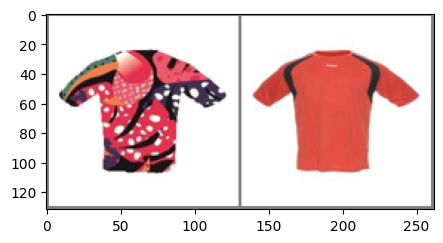

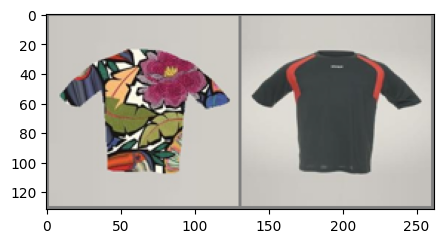

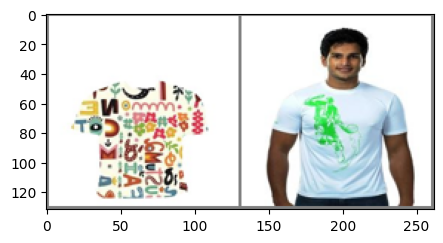

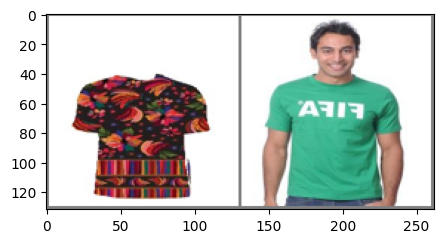

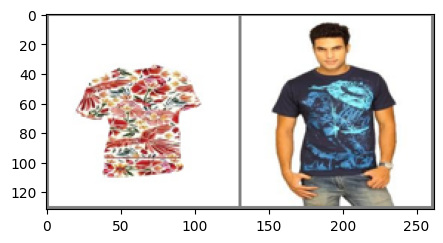

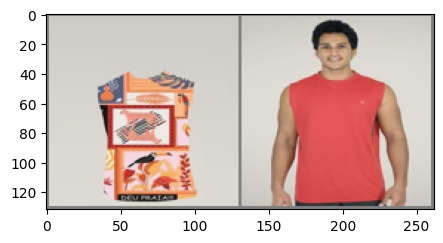

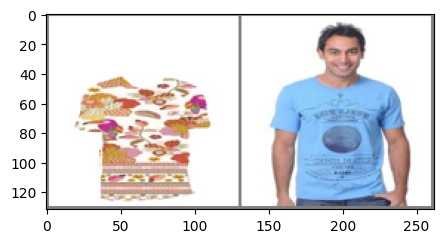

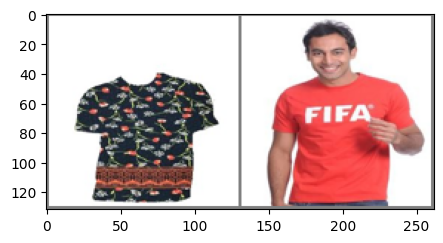

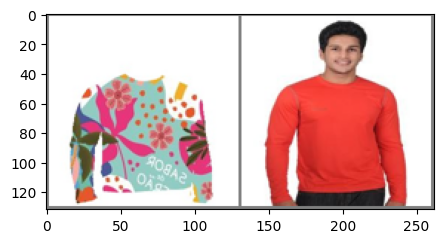

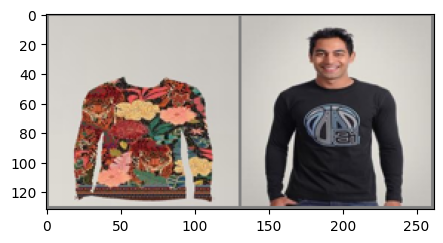

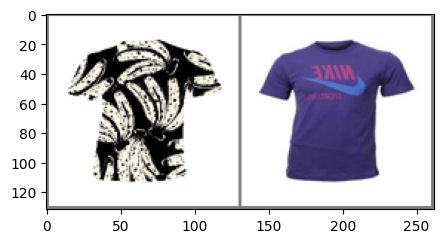

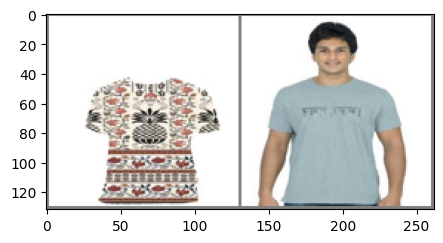

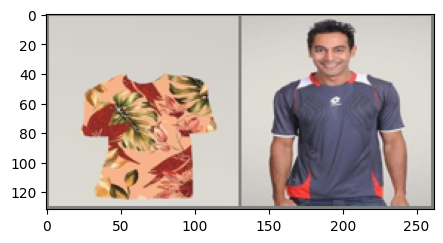

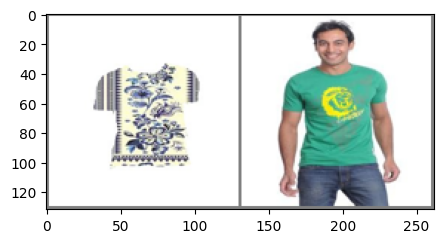

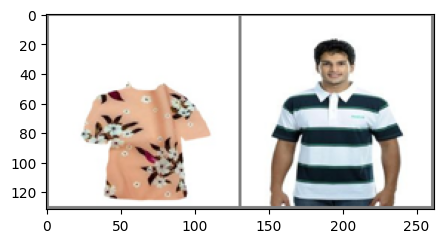

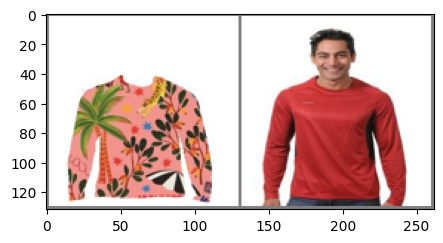

In [ ]:
#@title VISUALING SAMPLE DATA { run: "auto" }
pic_size = 5 #@param {type:"integer"} {type:"slider", min:1, max:30, step:1}

dataiter = iter(dataloader)
images = next(dataiter) # Use next(iterator) instead of iterator.next()
#TODO A - A - B
for i in range(len(images["B"])):
  imshow(make_grid([images["B"][i],images["A"][i]]), size=pic_size)

In [ ]:
#@title HELPER CLASSES - ReplayBuffer & LambdaLR
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [ ]:
#@title GENERATOR & DISCRIMINATOR
from torchvision.models import resnet18


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 3, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_size, 0.8),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        channels, self.h, self.w = img_shape

        self.fc = nn.Linear(latent_dim, self.h * self.w)

        self.down1 = UNetDown(channels + 1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        self.down7 = UNetDown(512, 512, normalize=False)
        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 512)
        self.up3 = UNetUp(1024, 512)
        self.up4 = UNetUp(1024, 256)
        self.up5 = UNetUp(512, 128)
        self.up6 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), nn.Conv2d(128, channels, 3, stride=1, padding=1), nn.Tanh()
        )

    def forward(self, x, z):
        # Propogate noise through fc layer and reshape to img shape
        z = self.fc(z).view(z.size(0), 1, self.h, self.w)
        d1 = self.down1(torch.cat((x, z), 1))
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        u1 = self.up1(d7, d6)
        u2 = self.up2(u1, d5)
        u3 = self.up3(u2, d4)
        u4 = self.up4(u3, d3)
        u5 = self.up5(u4, d2)
        u6 = self.up6(u5, d1)

        return self.final(u6)


##############################
#        Encoder
##############################


class Encoder(nn.Module):
    def __init__(self, latent_dim, input_shape):
        super(Encoder, self).__init__()
        resnet18_model = resnet18(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8, padding=0)
        # Output is mu and log(var) for reparameterization trick used in VAEs
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, img):
        out = self.feature_extractor(img)
        out = self.pooling(out)
        out = out.view(out.size(0), -1)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


##############################
#        Discriminator
##############################


class MultiDiscriminator(nn.Module):
    def __init__(self, input_shape):
        super(MultiDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        channels, _, _ = input_shape
        # Extracts discriminator models
        self.models = nn.ModuleList()
        for i in range(3):
            self.models.add_module(
                "disc_%d" % i,
                nn.Sequential(
                    *discriminator_block(channels, 64, normalize=False),
                    *discriminator_block(64, 128),
                    *discriminator_block(128, 256),
                    *discriminator_block(256, 512),
                    nn.Conv2d(512, 1, 3, padding=1)
                ),
            )

        self.downsample = nn.AvgPool2d(channels, stride=2, padding=[1, 1], count_include_pad=False)

    def compute_loss(self, x, gt):
        """Computes the MSE between model output and scalar gt"""
        loss = sum([torch.mean((out - gt) ** 2) for out in self.forward(x)])
        return loss

    def forward(self, x):
        outputs = []
        for m in self.models:
            outputs.append(m(x))
            x = self.downsample(x)
        return outputs

In [ ]:
#@title SETUP, LOSS, INITIALIZE MODELS and BUFFERS

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions
mae_loss = torch.nn.L1Loss()
input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator, encoder and discriminators
generator = Generator(hp.latent_dim, input_shape)
encoder = Encoder(hp.latent_dim, input_shape)
D_VAE = MultiDiscriminator(input_shape)
D_LR = MultiDiscriminator(input_shape)

if cuda:
    generator = generator.cuda()
    encoder.cuda()
    D_VAE = D_VAE.cuda()
    D_LR = D_LR.cuda()
    mae_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
D_VAE.apply(weights_init_normal)
D_LR.apply(weights_init_normal)

Using CUDA


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultiDiscriminator(
  (models): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (downsample): AvgPool2d(kernel_size=3, stride=2, padding=[1, 1])
)

In [ ]:
#@title SAMPLING IMAGES
def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    generator.eval()
    imgs = next(iter(val_dataloader))
    img_samples = None
    path = "images/%s/%s.png" % (hp.dataset_name, batches_done)
    for img_A, img_B in zip(imgs["A"], imgs["B"]):
        # Repeat input image by number of desired columns
        real_A = img_A.view(1, *img_A.shape).repeat(hp.latent_dim, 1, 1, 1)
        real_A = Variable(real_A.type(Tensor))
        # Sample latent representations
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (hp.latent_dim, hp.latent_dim))))
        # Generate samples
        fake_B = generator(real_A, sampled_z)
        # Concatenate samples horisontally
        fake_B = torch.cat([x for x in fake_B.data.cpu()], -1)
        img_sample = torch.cat((img_A, fake_B), -1)
        img_sample = img_sample.view(1, *img_sample.shape)
        # Concatenate with previous samples vertically
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)
    save_image(img_samples, path, nrow=8, normalize=True)
    generator.train()
    return path


In [ ]:
#@title OPTIMIZERS
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
#@title REPARAMETERIZE HELPER
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), hp.latent_dim))))
    z = sampled_z * std + mu
    return z

SAVE CHECKPOINT

In [ ]:
import os
import torch

# Função para salvar checkpoints
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    path = './drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/bicyclegan_checkpoints_8000_epochs'
    os.makedirs(path, exist_ok=True)
    filepath = os.path.join(path, filename)
    torch.save(state, filepath)
    print(f"Checkpoint salvo em: {filepath}")

# Função para carregar checkpoints
def load_checkpoint(filename):
    path = './drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/bicyclegan_checkpoints_8000_epochs'
    filepath = os.path.join(path, filename)
    if os.path.isfile(filepath):
        checkpoint = torch.load(filepath)
        print(f"Checkpoint carregado de: {filepath}")
        return checkpoint
    else:
        print("No checkpoint found at '{}'".format(filepath))
        return None

# Salvar modelo, otimizadores e epoch atual
checkpoint_path = "checkpoint.pth.tar"
save_interval = 250  # Salvar a cada 'save_interval' épocas

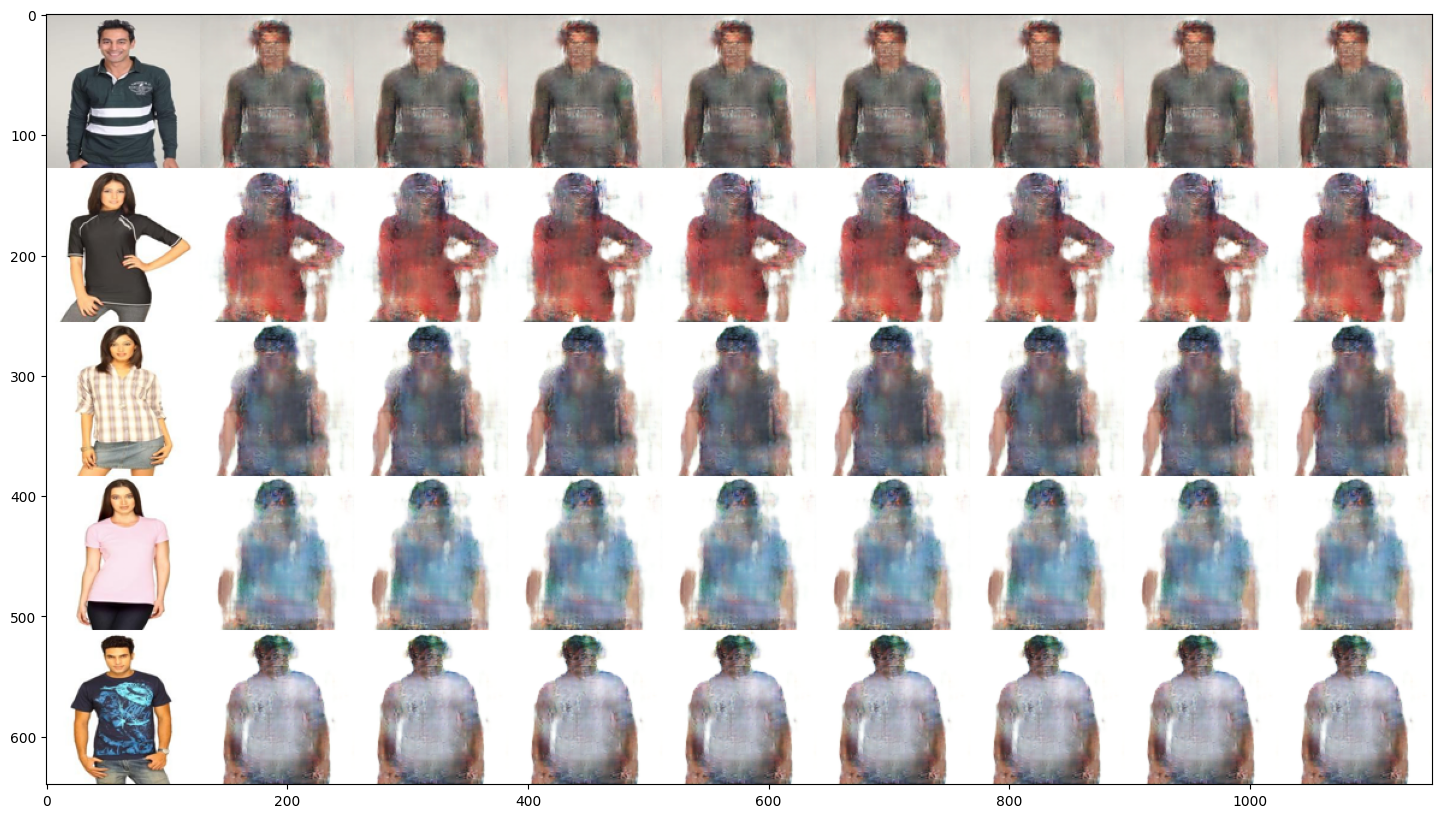

[Epoch 7999/8000] [Batch 6/7] [D VAE_loss: 0.238742, LR_loss: 0.633027] [G loss: 5.524402, pixel: 0.107317, kl: 0.000437, latent: 0.401566] ETA: 0:00:00.107835Checkpoint salvo em: ./drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/bicyclegan_checkpoints_8000_epochs/checkpoint.pth.tar


In [ ]:
#@title TRAINING
# Adversarial loss
valid = 1
fake = 0

prev_time = time.time()
for epoch in range(hp.epoch, hp.n_epochs):
    for i, batch in enumerate(dataloader):

        #TODO A B
        # Set model input
        real_B = Variable(batch["A"].type(Tensor))
        real_A = Variable(batch["B"].type(Tensor))

        # -------------------------------
        #  Train Generator and Encoder
        # -------------------------------

        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        # ----------
        # cVAE-GAN
        # ----------

        # Produce output using encoding of B (cVAE-GAN)
        mu, logvar = encoder(real_B)
        encoded_z = reparameterization(mu, logvar)
        fake_B = generator(real_A, encoded_z)

        # Pixelwise loss of translated image by VAE
        loss_pixel = mae_loss(fake_B, real_B)
        # Kullback-Leibler divergence of encoded B
        loss_kl = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - logvar - 1)
        # Adversarial loss
        loss_VAE_GAN = D_VAE.compute_loss(fake_B, valid)

        # ---------
        # cLR-GAN
        # ---------

        # Produce output using sampled z (cLR-GAN)
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), hp.latent_dim))))
        _fake_B = generator(real_A, sampled_z)
        # cLR Loss: Adversarial loss
        loss_LR_GAN = D_LR.compute_loss(_fake_B, valid)

        # ----------------------------------
        # Total Loss (Generator + Encoder)
        # ----------------------------------

        loss_GE = loss_VAE_GAN + loss_LR_GAN + hp.lambda_pixel * loss_pixel + hp.lambda_kl * loss_kl

        loss_GE.backward(retain_graph=True)
        optimizer_E.step()

        # ---------------------
        # Generator Only Loss
        # ---------------------

        # Latent L1 loss
        _mu, _ = encoder(_fake_B)
        loss_latent = hp.lambda_latent * mae_loss(_mu, sampled_z)

        loss_latent.backward()
        optimizer_G.step()

        # ----------------------------------
        #  Train Discriminator (cVAE-GAN)
        # ----------------------------------

        optimizer_D_VAE.zero_grad()

        loss_D_VAE = D_VAE.compute_loss(real_B, valid) + D_VAE.compute_loss(fake_B.detach(), fake)

        loss_D_VAE.backward()
        optimizer_D_VAE.step()

        # ---------------------------------
        #  Train Discriminator (cLR-GAN)
        # ---------------------------------

        optimizer_D_LR.zero_grad()

        loss_D_LR = D_LR.compute_loss(real_B, valid) + D_LR.compute_loss(_fake_B.detach(), fake)

        loss_D_LR.backward()
        optimizer_D_LR.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = hp.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D VAE_loss: %f, LR_loss: %f] [G loss: %f, pixel: %f, kl: %f, latent: %f] ETA: %s"
            % (
                epoch,
                hp.n_epochs,
                i,
                len(dataloader),
                loss_D_VAE.item(),
                loss_D_LR.item(),
                loss_GE.item(),
                loss_pixel.item(),
                loss_kl.item(),
                loss_latent.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % hp.sample_interval == 0:
          clear_output()
          visualise_output(sample_images(batches_done), 30, 10)

    # Salvar checkpoint a cada 'save_interval' épocas
    if (epoch + 1) % save_interval == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'D_VAE_state_dict': D_VAE.state_dict(),
            'D_LR_state_dict': D_LR.state_dict(),
            'optimizer_E_state_dict': optimizer_E.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_VAE_state_dict': optimizer_D_VAE.state_dict(),
            'optimizer_D_LR_state_dict': optimizer_D_LR.state_dict(),
        }, filename=checkpoint_path)

In [ ]:
# Carregar checkpoint
checkpoint = load_checkpoint(checkpoint_path)
if checkpoint:
    hp.epoch = checkpoint['epoch']
    generator.load_state_dict(checkpoint['generator_state_dict'])
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    D_VAE.load_state_dict(checkpoint['D_VAE_state_dict'])
    D_LR.load_state_dict(checkpoint['D_LR_state_dict'])
    optimizer_E.load_state_dict(checkpoint['optimizer_E_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D_VAE.load_state_dict(checkpoint['optimizer_D_VAE_state_dict'])
    optimizer_D_LR.load_state_dict(checkpoint['optimizer_D_LR_state_dict'])

Checkpoint carregado de: ./drive/MyDrive/MBAIA_DATASETS/TCC/fashion_dataset_256/bicyclegan_checkpoints_4000_epochs/checkpoint.pth.tar


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

inception_model = hub.KerasLayer("https://tfhub.dev/tensorflow/tfgan/eval/inception/1", trainable=False)

def calculate_inception_score(images, inception_model):
    images = tf.image.resize(images, [299, 299])  # Redimensionar imagens
    images = tf.keras.applications.inception_v3.preprocess_input(images)  # Pré-processamento

    # Obter previsões de logits do modelo Inception
    #logits = inception_model(images)
    logits = inception_model(images)['logits']

    # Calcular probabilidades softmax
    p_yx = tf.nn.softmax(logits)

    # Calcular as marginais
    p_y = tf.reduce_mean(p_yx, axis=0)

    # Calcular o Inception Score
    kl_divergence = p_yx * (tf.math.log(p_yx) - tf.math.log(p_y))
    score = tf.reduce_mean(tf.reduce_sum(kl_divergence, axis=1))
    return tf.exp(score)

In [ ]:
def generate_test_images():
    generator.eval()
    imgs = next(iter(val_dataloader))
    img_samples = None
    path = "test_images/%s.png" % (hp.dataset_name)
    # Create the 'test_images' directory if it doesn't exist
    os.makedirs('test_images', exist_ok=True)

    for img_A, img_B in zip(imgs["A"], imgs["B"]):
        real_A = img_A.view(1, *img_A.shape).repeat(hp.latent_dim, 1, 1, 1)
        real_A = Variable(real_A.type(Tensor))
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (hp.latent_dim, hp.latent_dim))))
        fake_B = generator(real_A, sampled_z)
        fake_B = torch.cat([x for x in fake_B.data.cpu()], -1)
        img_sample = torch.cat((img_A, fake_B), -1)
        img_sample = img_sample.view(1, *img_sample.shape)
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)

    save_image(img_samples, path, nrow=8, normalize=True)
    generator.train()
    return path


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


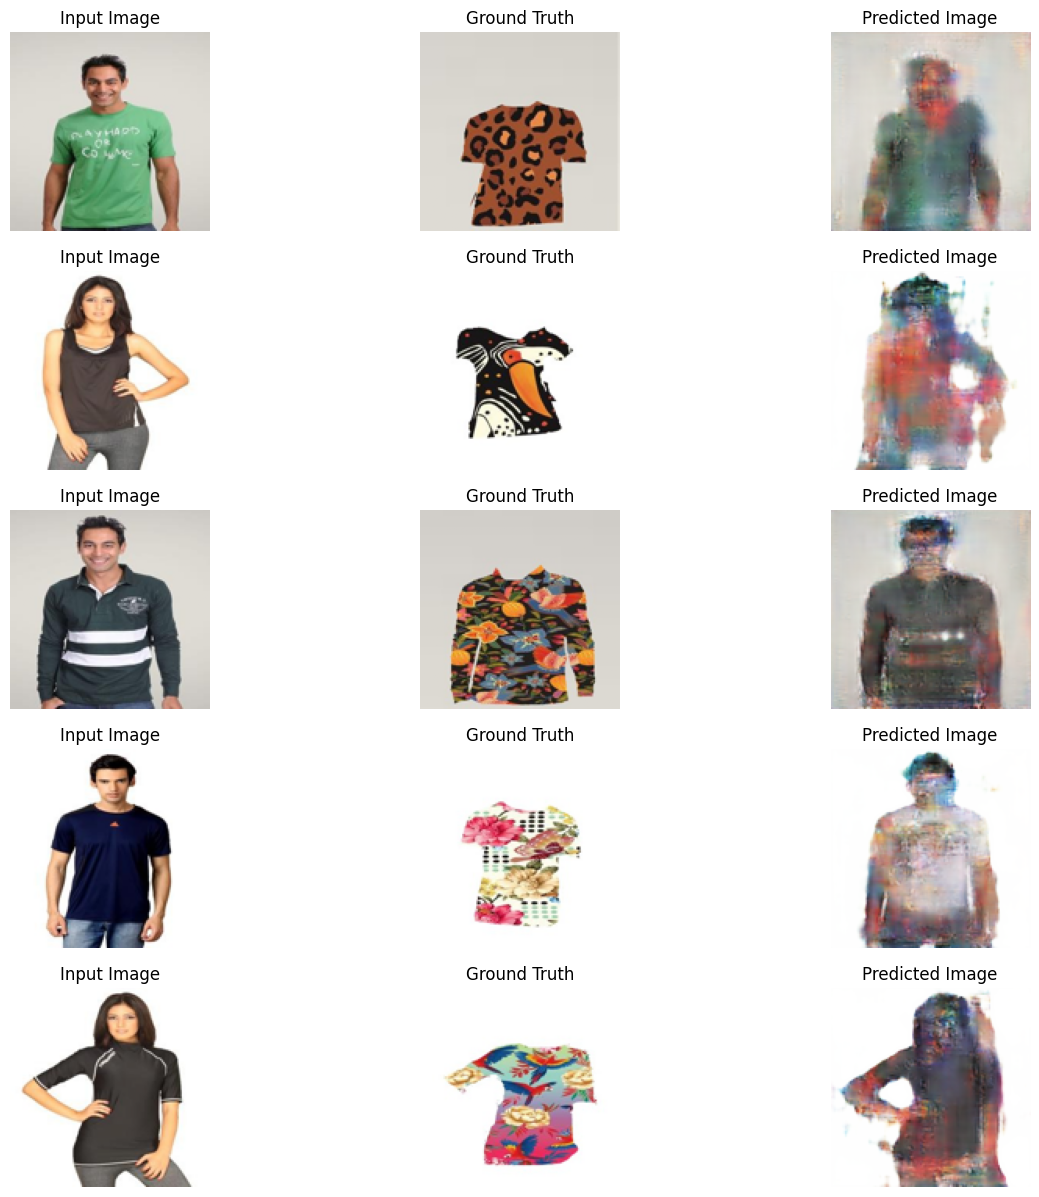

Inception Score: 1.0063849687576294


In [ ]:

def display_generated_images(model, dataloader):
    model.eval()
    imgs = next(iter(dataloader))
    fig = plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    # Lista para armazenar as imagens geradas
    predicted_images = []

    for i in range(len(imgs["A"])):
        img_A = imgs["A"][i].unsqueeze(0)
        img_B = imgs["B"][i].unsqueeze(0)

        with torch.no_grad():
            sampled_z = Variable(Tensor(np.random.normal(0, 1, (1, hp.latent_dim))))
            fake_B = model(img_A.cuda(), sampled_z.cuda())

        # Normalize images for display
        img_A = (img_A * 0.5 + 0.5).cpu().numpy().transpose(0, 2, 3, 1)
        img_B = (img_B * 0.5 + 0.5).cpu().numpy().transpose(0, 2, 3, 1)
        fake_B = (fake_B * 0.5 + 0.5).cpu().numpy().transpose(0, 2, 3, 1)

        display_list = [img_A[0], img_B[0], fake_B[0]]

        for j in range(3):
            ax = fig.add_subplot(len(imgs["A"]), 3, i * 3 + j + 1)
            ax.set_title(title[j])
            ax.imshow(display_list[j])
            ax.axis('off')

        # Adicionar imagem gerada à lista para cálculo do Inception Score
        predicted_images.append(fake_B[0])

    plt.show()

    # Converter a lista de imagens geradas para um tensor
    # Verificar se a lista de imagens geradas não está vazia
    if predicted_images:
        # Converter a lista de imagens geradas para um tensor
        predicted_images = tf.stack(predicted_images)

        # Calcular o Inception Score para as imagens geradas
        is_score = calculate_inception_score(predicted_images, inception_model)
        print(f"Inception Score: {is_score}")
    else:
        print("Nenhuma imagem válida foi gerada.")

    model.train()

# Exibir imagens geradas após o treinamento
display_generated_images(generator, val_dataloader)